In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


<div class="alert alert-block alert-info"> <b>Dependencies</b> </div>


In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
#from tensorflow.python.keras.layers.convolutional import Conv1D, MaxPooling1D
#from tensorflow.python.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from keras.layers import TimeDistributed
from tensorflow.keras.layers import Dense, Conv1D , MaxPooling1D , LSTM, TimeDistributed, Flatten, GRU, RepeatVector
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import plotly.offline as py #visualization
py.init_notebook_mode(connected=True) #visualization
import plotly.graph_objs as go #visualization
import plotly.tools as tls #visualization
import plotly.figure_factory as ff


from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from tensorflow.compat.v1 import set_random_seed
from numpy.random import seed
set_random_seed(1)
seed(1)

In [103]:
pd.set_option('display.max_columns', None)

In [104]:
train = pd.read_csv('/Users/moumi/Documents/SCU/Python/jupyter/DL Project/demand-forecasting-kernels-only/train.csv', parse_dates=['date'])

In [105]:
train.shape

(913000, 4)

In [106]:
#Time period of the train dataset
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2017-12-31


<div class="alert alert-block alert-info"> <b> Data Cleaning and Pre-processing</b> </div>


In [107]:
#adding features to the training dataset to granular level
train['date']=pd.to_datetime(train['date'], infer_datetime_format=True)
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['week'] = train['date'].dt.week
train['dayofweek'] = train['date'].dt.dayofweek
train['weekday'] = train['date'].dt.weekday
train['dayofyear'] = train['date'].dt.dayofyear
train['quarter'] = train['date'].dt.quarter
train['daily_avg']=train.groupby(['item','store','dayofweek'])['sales'].transform('mean')
train['monthly_avg']=train.groupby(['item','store','month'])['sales'].transform('mean')
train["mean_store_item_month"] = train.groupby(['month',"item","store"])["sales"].transform("mean")
daily_avg=train.groupby(['item','store','dayofweek'])['sales'].mean().reset_index()
monthly_avg=train.groupby(['item','store','month'])['sales'].mean().reset_index()
mean_store_item_month = train.groupby(['month','item','store'])['sales'].mean().reset_index()
train.dtypes


date                     datetime64[ns]
store                             int64
item                              int64
sales                             int64
year                              int64
month                             int64
day                               int64
week                              int64
dayofweek                         int64
weekday                           int64
dayofyear                         int64
quarter                           int64
daily_avg                       float64
monthly_avg                     float64
mean_store_item_month           float64
dtype: object

In [108]:
#making a copy of the training data to use to for further processing
train_v2 = train.copy()
train.head()

date  store  item  sales  year  month  day  week  dayofweek  weekday  \
0 2013-01-01      1     1     13  2013      1    1     1          1        1   
1 2013-01-02      1     1     11  2013      1    2     1          2        2   
2 2013-01-03      1     1     14  2013      1    3     1          3        3   
3 2013-01-04      1     1     13  2013      1    4     1          4        4   
4 2013-01-05      1     1     10  2013      1    5     1          5        5   

   dayofyear  quarter  daily_avg  monthly_avg  mean_store_item_month  
0          1        1  18.168582    13.709677              13.709677  
1          2        1  18.793103    13.709677              13.709677  
2          3        1  19.452107    13.709677              13.709677  
3          4        1  21.015326    13.709677              13.709677  
4          5        1  22.973180    13.709677              13.709677

In [109]:
# Create New DataFrame of Specific column by DataFrame.assign() method.
sales_df = pd.DataFrame().assign(sales=train_v2['sales'])

def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Drop rows with NaN values
#     if dropnan:
#         agg.dropna(inplace=True)
    return agg

#introducing look-back feature
window = 29
lag = 30
sales_series = series_to_supervised(sales_df, window=window, lag=lag)
sales_series = sales_series.drop('sales(t)', axis=1)
sales_series = sales_series.drop('sales(t+30)', axis=1)
sales_series.shape

(913000, 29)

In [110]:
train_v2.shape

(913000, 15)

In [111]:
#merging training dataset with the sales_series created above with the look-back feature
train_v2 = pd.concat([train_v2, sales_series], axis=1)
#replacing NaN values with 0
train_v2 = train_v2.replace(np.nan,0)
train_v2.head()

date  store  item  sales  year  month  day  week  dayofweek  weekday  \
0 2013-01-01      1     1     13  2013      1    1     1          1        1   
1 2013-01-02      1     1     11  2013      1    2     1          2        2   
2 2013-01-03      1     1     14  2013      1    3     1          3        3   
3 2013-01-04      1     1     13  2013      1    4     1          4        4   
4 2013-01-05      1     1     10  2013      1    5     1          5        5   

   dayofyear  quarter  daily_avg  monthly_avg  mean_store_item_month  \
0          1        1  18.168582    13.709677              13.709677   
1          2        1  18.793103    13.709677              13.709677   
2          3        1  19.452107    13.709677              13.709677   
3          4        1  21.015326    13.709677              13.709677   
4          5        1  22.973180    13.709677              13.709677   

   sales(t-29)  sales(t-28)  sales(t-27)  sales(t-26)  sales(t-25)  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          0.0          0.0   
2          0.0          0.0          0.0          0.0          0.0   
3          0.0          0.0          0.0          0.0          0.0   
4          0.0          0.0          0.0          0.0          0.0   

   sales(t-24)  sales(t-23)  sales(t-22)  sales(t-21)  sales(t-20)  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          0.0          0.0   
2          0.0          0.0          0.0          0.0          0.0   
3          0.0          0.0          0.0          0.0          0.0   
4          0.0          0.0          0.0          0.0          0.0   

   sales(t-19)  sales(t-18)  sales(t-17)  sales(t-16)  sales(t-15)  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          0.0          0.0   
2          0.0          0.0          0.0          0.0          0.0   
3          0.0          0.0          0.0          0.0          0.0   
4          0.0          0.0          0.0          0.0          0.0   

   sales(t-14)  sales(t-13)  sales(t-12)  sales(t-11)  sales(t-10)  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          0.0          0.0   
2          0.0          0.0          0.0          0.0          0.0   
3          0.0          0.0          0.0          0.0          0.0   
4          0.0          0.0          0.0          0.0          0.0   

   sales(t-9)  sales(t-8)  sales(t-7)  sales(t-6)  sales(t-5)  sales(t-4)  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         0.0         0.0        13.0   

   sales(t-3)  sales(t-2)  sales(t-1)  
0         0.0         0.0         0.0  
1         0.0         0.0        13.0  
2         0.0        13.0        11.0  
3        13.0        11.0        14.0  
4        11.0        14.0        13.0

In [112]:
train_v2.dtypes

date                     datetime64[ns]
store                             int64
item                              int64
sales                             int64
year                              int64
month                             int64
day                               int64
week                              int64
dayofweek                         int64
weekday                           int64
dayofyear                         int64
quarter                           int64
daily_avg                       float64
monthly_avg                     float64
mean_store_item_month           float64
sales(t-29)                     float64
sales(t-28)                     float64
sales(t-27)                     float64
sales(t-26)                     float64
sales(t-25)                     float64
sales(t-24)                     float64
sales(t-23)                     float64
sales(t-22)                     float64
sales(t-21)                     float64
sales(t-20)                     float64


In [113]:
#feature set specific to machine learning models
train['is_month_start'] = train['date'].dt.is_month_start
train['is_month_end'] =train['date'].dt.is_month_end
train['is_quarter_start'] = train['date'].dt.is_quarter_start
train['is_quarter_end'] = train['date'].dt.is_quarter_end
train['is_year_start'] = train['date'].dt.is_year_start
train['is_year_end'] = train['date'].dt.is_year_end

#Create mask for boolean values for train dataset
train['is_month_start'] = train['is_month_start'].replace({True: 1, False: 0})
train['is_month_end'] = train['is_month_end'].replace({True: 1, False: 0})
train['is_quarter_start'] = train['is_quarter_start'].replace({True: 1, False: 0})
train['is_quarter_end'] = train['is_quarter_end'].replace({True: 1, False: 0})
train['is_year_start'] = train['is_year_start'].replace({True: 1, False: 0})
train['is_year_end'] = train['is_year_end'].replace({True: 1, False: 0})

#convert float to int
train['daily_avg']=train['daily_avg'].astype(np.int64)
train['monthly_avg']=train['monthly_avg'].astype(np.int64)
train['mean_store_item_month']=train['mean_store_item_month'].astype(np.int64)
train.dtypes

date                     datetime64[ns]
store                             int64
item                              int64
sales                             int64
year                              int64
month                             int64
day                               int64
week                              int64
dayofweek                         int64
weekday                           int64
dayofyear                         int64
quarter                           int64
daily_avg                         int64
monthly_avg                       int64
mean_store_item_month             int64
is_month_start                    int64
is_month_end                      int64
is_quarter_start                  int64
is_quarter_end                    int64
is_year_start                     int64
is_year_end                       int64
dtype: object

<div class="alert alert-block alert-info"> <b>Exploratory Data Analysis</b> </div>


In [16]:
#Plotting overall daily sales
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()
daily_sales_sc = go.Scatter(x=daily_sales['date'], y=daily_sales['sales'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
iplot(fig)

In [17]:
#Plotting store daily sales
store_daily_sales_sc = []
for store in store_daily_sales['store'].unique():
    current_store_daily_sales = store_daily_sales[(store_daily_sales['store'] == store)]
    store_daily_sales_sc.append(go.Scatter(x=current_store_daily_sales['date'], y=current_store_daily_sales['sales'], name=('Store %s' % store)))

layout = go.Layout(title='Store daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=store_daily_sales_sc, layout=layout)
iplot(fig)

In [18]:
#Plotting daily sales by item
item_daily_sales_sc = []
for item in item_daily_sales['item'].unique():
    current_item_daily_sales = item_daily_sales[(item_daily_sales['item'] == item)]
    item_daily_sales_sc.append(go.Scatter(x=current_item_daily_sales['date'], y=current_item_daily_sales['sales'], name=('Item %s' % item)))

layout = go.Layout(title='Item daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=item_daily_sales_sc, layout=layout)
iplot(fig)

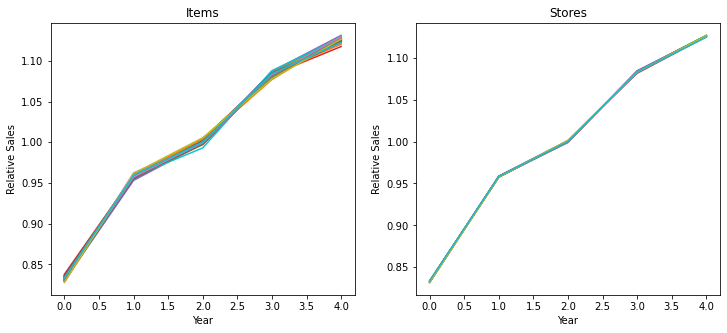

All items and stores follow a similar growth in sales over the years.


In [19]:
#plotting sales over years 
agg_year_item = pd.pivot_table(train, index='year', columns='item',
                               values='sales', aggfunc=np.mean).values
agg_year_store = pd.pivot_table(train, index='year', columns='store',
                                values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_year_item / agg_year_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Year")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_year_store / agg_year_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Year")
plt.ylabel("Relative Sales")
plt.show()
print("All items and stores follow a similar growth in sales over the years.")

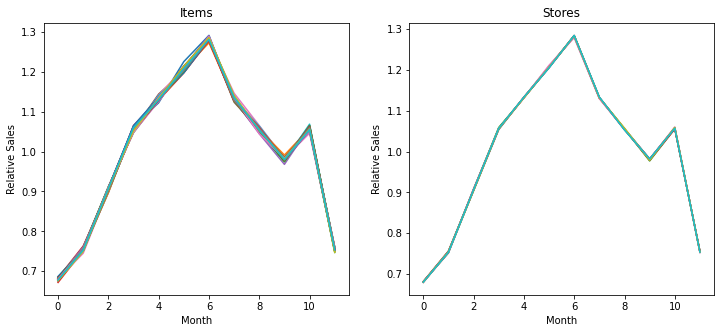

All items and stores share a common pattern in sales over the months as well.


In [20]:
#Plotting items and stores relative sales over months
agg_month_item = pd.pivot_table(train, index='month', columns='item',
                                values='sales', aggfunc=np.mean).values
agg_month_store = pd.pivot_table(train, index='month', columns='store',
                                 values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_month_item / agg_month_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Month")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_month_store / agg_month_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Month")
plt.ylabel("Relative Sales")
plt.show()
print("All items and stores share a common pattern in sales over the months as well.")

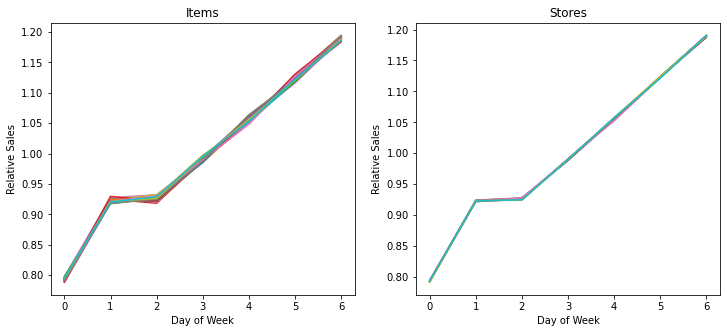

All items and stores also seem to share a common pattern in sales over the days of the week as well.


In [21]:
#Plotting relative sales of items and stores over the day of week
agg_dow_item = pd.pivot_table(train, index='dayofweek', columns='item',
                              values='sales', aggfunc=np.mean).values
agg_dow_store = pd.pivot_table(train, index='dayofweek', columns='store',
                               values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_dow_item / agg_dow_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_dow_store / agg_dow_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.show()
print("All items and stores also seem to share a common pattern in sales over the days of the week as well.")

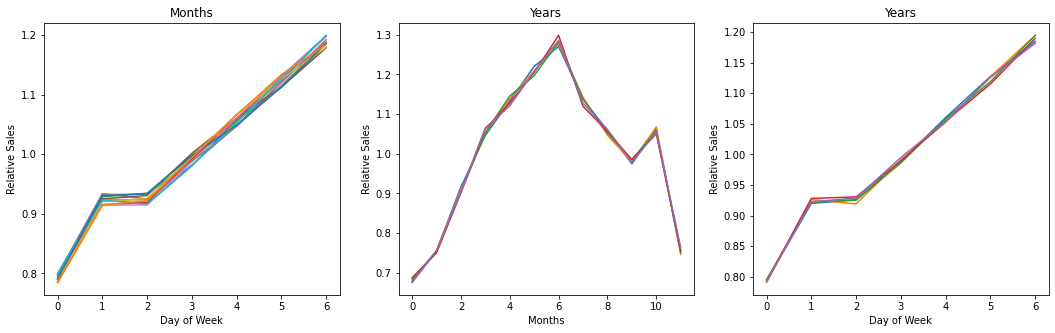

In [22]:
#checking for degeneracies in the data which can lead to missing important trends in complex datasets
agg_dow_month = pd.pivot_table(train, index='dayofweek', columns='month',
                               values='sales', aggfunc=np.mean).values
agg_month_year = pd.pivot_table(train, index='month', columns='year',
                                values='sales', aggfunc=np.mean).values
agg_dow_year = pd.pivot_table(train, index='dayofweek', columns='year',
                              values='sales', aggfunc=np.mean).values

plt.figure(figsize=(18, 5))
plt.subplot(131)
plt.plot(agg_dow_month / agg_dow_month.mean(0)[np.newaxis])
plt.title("Months")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.subplot(132)
plt.plot(agg_month_year / agg_month_year.mean(0)[np.newaxis])
plt.title("Years")
plt.xlabel("Months")
plt.ylabel("Relative Sales")
plt.subplot(133)
plt.plot(agg_dow_year / agg_dow_year.mean(0)[np.newaxis])
plt.title("Years")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.show()


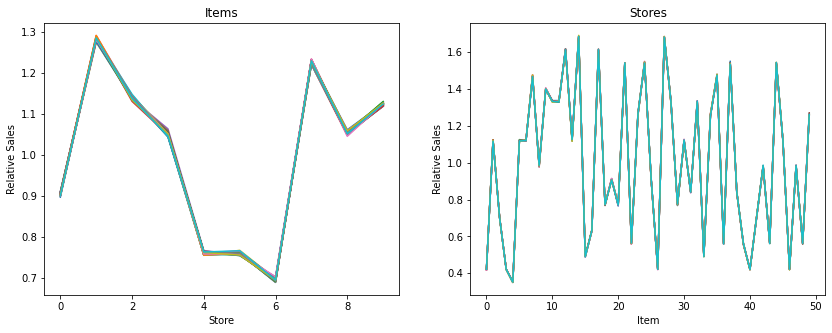

In [23]:
#checking for degeneracies in the data - items and sales which can lead to missing important trends in complex datasets
agg_store_item = pd.pivot_table(train, index='store', columns='item',
                                values='sales', aggfunc=np.mean).values

plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(agg_store_item / agg_store_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Store")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_store_item.T / agg_store_item.T.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Item")
plt.ylabel("Relative Sales")
plt.show()


<div class="alert alert-block alert-info"> <b>Train, Validation and Test Data Preparation</b> </div>

In [115]:
##creating test dataset from training dataset for machine learning models
test = train[(train['date'] > '2017-08-01')]
train = train[(train['date'] <= '2017-07-31')]
#Dropping target column - date column as other custom created date features will be used instead to train the model
train= train.drop(['date'], axis = 1)

In [116]:
#creating test dataset from training dataset for deep learning models
test_v2 = train_v2[(train_v2['date'] > '2017-08-01')]
train_v2 = train_v2[(train_v2['date'] <= '2017-07-31')]
#Dropping target column - date column as other custom created date features will be used instead to train the model
train_v2= train_v2.drop(['date'], axis = 1)

In [117]:
train_v2.shape

(836500, 43)

In [118]:
#making a copy of train and test dataset for machine learning models
test_copy = test.copy()
train_copy = train.copy()
#test configurations for machine learning models
x_test = test_copy.drop(['sales', 'date'], axis=1)
y_test = test_copy.pop('sales')
y_date = test_copy.pop('date')
#training configurations for machine learning models and splitting validation data set by 20%
x_train,x_val,y_train,y_val = train_test_split(train_copy.drop('sales',axis=1),train_copy.pop('sales'),random_state=42,test_size=0.2)
print('Observations: %d' % (len(train_copy)))
print('Training Observations: %d' % (len(x_train)))
print('Validation Observations: %d' % (len(x_val)))
print('Testing Observations: %d' % (len(x_test)))


Observations: 836500
Training Observations: 669200
Validation Observations: 167300
Testing Observations: 76000


In [119]:
#making a copy of train and test dataset for deep learning models
test_v2_copy = test_v2.copy()
train_v2_copy = train_v2.copy()
#test configurations for deep learning models
x_test_v2 = test_v2_copy.drop(['sales', 'date'], axis=1)
y_test_v2 = test_v2_copy.pop('sales')
y_date_v2 = test_v2_copy.pop('date')
#training configurations for deep learning models and splitting validation data set by 20%
x_train_v2,x_val_v2,y_train_v2,y_val_v2 = train_test_split(train_v2_copy.drop('sales',axis=1),train_v2_copy.pop('sales'),random_state=42,test_size=0.2)
print('Observations: %d' % (len(train_v2_copy)))
print('Training Observations: %d' % (len(x_train_v2)))
print('Validation Observations: %d' % (len(x_val_v2)))
print('Testing Observations: %d' % (len(x_test_v2)))


Observations: 836500
Training Observations: 669200
Validation Observations: 167300
Testing Observations: 76000


In [121]:
x_train_v2.shape

(669200, 42)

In [122]:
x_test_v2.shape

(76000, 42)

<div class="alert alert-block alert-info"> <b><h1>Machine Learning Models</h1></b> </div>


<div class="alert alert-block alert-info"> <b><h3> Linear Regression model</h3></b> </div>


In [167]:
#Linear Regression Model
model_lr = LinearRegression()
model_lr.fit(x_train, y_train)
#prediction on validation data
model_lr_preds_validation = model_lr.predict(x_val)
#prediction on test data
model_lr_preds_test = model_lr.predict(x_test)

In [168]:
#calculating various error metrics on validation data
print('Linear regressor validation rmse:', np.sqrt(mean_squared_error(y_val, model_lr_preds_validation)))
print ('Linear regressor validation R2 score', r2_score(y_val, model_lr_preds_validation))
print ('Linear regressor validation MAE score', mean_absolute_error(y_val, model_lr_preds_validation))
print ('Linear regressor validation MAPE score', mean_absolute_percentage_error(y_val, model_lr_preds_validation))
print ('Linear regressor validation MSE score', mean_squared_error(y_val, model_lr_preds_validation))

Linear regressor validation rmse: 8.4023027038972
Linear regressor validation R2 score 0.913750314096253
Linear regressor validation MAE score 6.482387381009362
Linear regressor validation MAPE score 109449852575.16565
Linear regressor validation MSE score 70.5986907279182


In [170]:
#calculating various error metrics on prediction test data
print('Linear regressor test rmse:', np.sqrt(mean_squared_error(y_test, model_lr_preds_test)))
print ('Linear regressor test R2 score', r2_score(y_test, model_lr_preds_test))
print ('Linear regressor test MAE score', mean_absolute_error(y_test, model_lr_preds_test))
print ('Linear regressor test MAPE score', mean_absolute_percentage_error(y_test, model_lr_preds_test))
print ('Linear regressor test MSE score', mean_squared_error(y_test, model_lr_preds_test))

Linear regressor test rmse: 9.325051081601336
Linear regressor test R2 score 0.9051953510903652
Linear regressor test MAE score 7.372624658604641
Linear regressor test MAPE score 0.1740674910689577
Linear regressor test MSE score 86.95657767447425


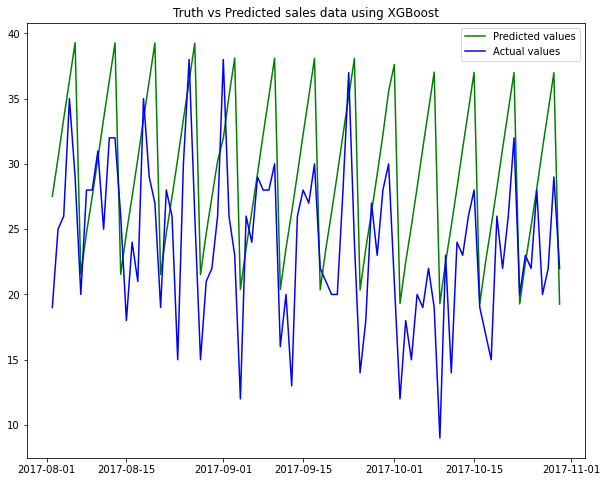

In [182]:
y_pred_linear_df = pd.DataFrame(model_lr_preds_test)
plt.figure(figsize=(10, 8))

plt.plot(y_date[:90], model_lr_preds_test[:90], 'b', color='green', label='Predicted values')
plt.plot(y_date[:90], y_test[:90], 'b', color='blue', label='Actual values')
plt.title('Truth vs Predicted sales data using XGBoost')
plt.legend()

plt.show()


<div class="alert alert-block alert-info"> <b><h3> XGBoost </h3></b> </div>


In [171]:
#XGBoost Model
def XGBmodel(x_train,x_test,y_train,y_test):
    matrix_train = xgb.DMatrix(x_train,label=y_train)
    matrix_test = xgb.DMatrix(x_test,label=y_test)
    model=xgb.train(params={'objective':'reg:squarederror','eval_metric':'mae'}
                  ,dtrain=matrix_train,num_boost_round=500, 
                    early_stopping_rounds=20,evals=[(matrix_test,'test')],)
    return model

model_xgb=XGBmodel(x_train_v2, x_val_v2,y_train_v2,y_val_v2)

[0]	test-mae:35.81106
[1]	test-mae:25.08425
[2]	test-mae:17.66556
[3]	test-mae:12.71427
[4]	test-mae:9.62637
[5]	test-mae:7.84629
[6]	test-mae:6.87574
[7]	test-mae:6.36646
[8]	test-mae:6.10356
[9]	test-mae:5.96548
[10]	test-mae:5.88477
[11]	test-mae:5.84295
[12]	test-mae:5.81517
[13]	test-mae:5.79453
[14]	test-mae:5.78127
[15]	test-mae:5.77116
[16]	test-mae:5.76048
[17]	test-mae:5.75232
[18]	test-mae:5.74350
[19]	test-mae:5.73720
[20]	test-mae:5.73227
[21]	test-mae:5.72714
[22]	test-mae:5.72019
[23]	test-mae:5.71376
[24]	test-mae:5.71083
[25]	test-mae:5.70765
[26]	test-mae:5.70202
[27]	test-mae:5.69843
[28]	test-mae:5.69464
[29]	test-mae:5.69138
[30]	test-mae:5.68876
[31]	test-mae:5.68702
[32]	test-mae:5.68524
[33]	test-mae:5.68392
[34]	test-mae:5.68084
[35]	test-mae:5.67817
[36]	test-mae:5.67626
[37]	test-mae:5.67485
[38]	test-mae:5.67213
[39]	test-mae:5.66961
[40]	test-mae:5.66772
[41]	test-mae:5.66664
[42]	test-mae:5.66542
[43]	test-mae:5.66378
[44]	test-mae:5.66287
[45]	test-mae:5.

In [172]:
model_xgb.save_model("MODEL_XGB.json")

In [173]:
#Prediction on validation data
model_xgb_valid_pred = model_xgb.predict(xgb.DMatrix(x_val_v2), ntree_limit = model_xgb.best_ntree_limit)
#Prediction on test data
model_xgb_preds_test = model_xgb.predict(xgb.DMatrix(x_test_v2))

In [174]:
#Calculating various error metrics
print('XGBoost validation mse:', mean_squared_error(y_val_v2, model_xgb_valid_pred))
print('XGBoost validation rmse:', np.sqrt(mean_squared_error(y_val_v2, model_xgb_valid_pred)))
print ('XGBoost validation R2 score', r2_score(y_val_v2, model_xgb_valid_pred))
print ('XGBoost validation MAE score', mean_absolute_error(y_val_v2, model_xgb_valid_pred))
print ('XGBoost validation MAPE score', mean_absolute_percentage_error(y_val_v2, model_xgb_valid_pred))

XGBoost validation mse: 53.82403867888271
XGBoost validation rmse: 7.336486807654104
XGBoost validation R2 score 0.9342437319692536
XGBoost validation MAE score 5.629667578513082
XGBoost validation MAPE score 256261829449.27054


In [178]:
print('XGBoost test mse:', mean_squared_error(y_test_v2, model_xgb_preds_test))
print('XGBoost test rmse:', np.sqrt(mean_squared_error(y_test_v2, model_xgb_preds_test)))
print ('XGBoost test R2 score', r2_score(y_test_v2, model_xgb_preds_test))
print ('XGBoost test MAE score', mean_absolute_error(y_test_v2, model_xgb_preds_test))
print ('XGBoost test MAPE score', mean_absolute_percentage_error(y_test_v2, model_xgb_preds_test))

XGBoost test mse: 63.25735218950469
XGBoost test rmse: 7.95344907505572
XGBoost test R2 score 0.9310334971124383
XGBoost test MAE score 6.113887501202131
XGBoost test MAPE score 0.1251090435534437


In [179]:
y_pred_xgb = model_xgb.predict(xgb.DMatrix(x_test_v2))

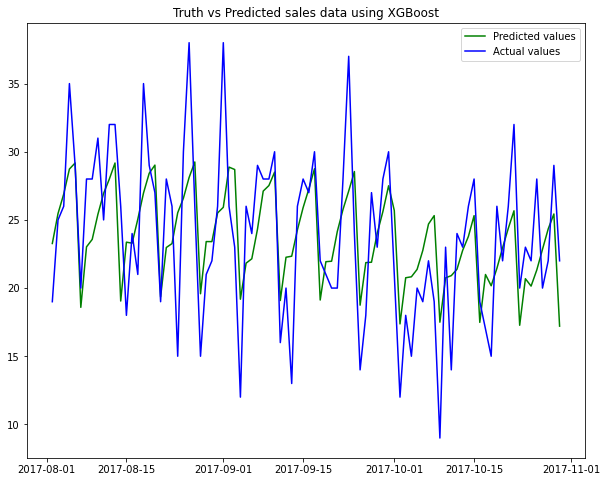

In [190]:
#plotting Truth vs Predicted sales data - XGBoost
y_pred_xgb_df = pd.DataFrame(y_pred_xgb)
plt.figure(figsize=(10, 8))

plt.plot(y_date[:90], y_pred_xgb[:90], 'b', color='green', label='Predicted values')
plt.plot(y_date[:90], y_test_v2[:90], 'b', color='blue', label='Actual values')
plt.title('Truth vs Predicted sales data using XGBoost')
plt.legend()

plt.show()

<div class="alert alert-block alert-info"> <b><h1>Deep Learning Models</h1></b> </div>

<div class="alert alert-block alert-info"> <b><h1>CNN</h1></b> </div>

### CNN for Time Series Forecasting

* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape [samples, timesteps, features].

#### Data preprocess
* Reshape into [samples, timesteps, features].
* This same reshaped data will be used on the CNN, LSTM, CNN+LSTM, GRU model.

In [125]:
x_train_v2.shape

(669200, 42)

In [126]:
#reshaping data into [samples,features,timesteps]
#data to be used for CNN, LSTM, CNN+LSTM and GRU Models
x_train_series_v2 = x_train_v2.values.reshape((x_train_v2.shape[0], x_train_v2.shape[1], 1))
x_val_series_v2 = x_val_v2.values.reshape((x_val_v2.shape[0], x_val_v2.shape[1], 1))
print('Train set shape', x_train_series_v2.shape)
print('Validation set shape', x_val_series_v2.shape)

Train set shape (669200, 42, 1)
Validation set shape (167300, 42, 1)


In [127]:
#Setting model parameters
epochs = 15
batch = 128
lr = 0.0003
adam = optimizers.Adam(lr)

In [129]:
#CNN Model
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(x_train_series_v2.shape[1], x_train_series_v2.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape'])
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 41, 64)            192       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 20, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 50)                64050     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 64,293
Trainable params: 64,293
Non-trainable params: 0
__________________________________________________

In [130]:
#fitting model on training data 
cnn_history = model_cnn.fit(x_train_series_v2, y_train_v2, validation_data=(x_val_series_v2, y_val_v2), epochs=epochs, verbose=2)



Epoch 1/15
20913/20913 - 85s - loss: 69.4050 - mse: 69.4050 - mae: 6.3832 - mape: 15.3538 - val_loss: 60.5676 - val_mse: 60.5676 - val_mae: 5.9631 - val_mape: 61667.6992 - 85s/epoch - 4ms/step
Epoch 2/15
20913/20913 - 98s - loss: 61.8989 - mse: 61.8989 - mae: 6.0330 - mape: 14.4040 - val_loss: 60.5081 - val_mse: 60.5081 - val_mae: 5.9399 - val_mape: 56889.7930 - 98s/epoch - 5ms/step
Epoch 3/15
20913/20913 - 83s - loss: 60.0349 - mse: 60.0349 - mae: 5.9498 - mape: 14.1843 - val_loss: 58.5410 - val_mse: 58.5410 - val_mae: 5.8922 - val_mape: 61793.0625 - 83s/epoch - 4ms/step
Epoch 4/15
20913/20913 - 87s - loss: 58.9745 - mse: 58.9745 - mae: 5.8990 - mape: 14.0596 - val_loss: 59.4441 - val_mse: 59.4441 - val_mae: 5.9306 - val_mape: 48696.1484 - 87s/epoch - 4ms/step
Epoch 5/15
20913/20913 - 76s - loss: 58.4888 - mse: 58.4888 - mae: 5.8752 - mape: 14.0035 - val_loss: 57.0958 - val_mse: 57.0958 - val_mae: 5.8000 - val_mape: 52021.7383 - 76s/epoch - 4ms/step
Epoch 6/15
20913/20913 - 71s - loss

In [131]:
model_cnn.save("CNN_MODEL.h5")

In [134]:
#predicting on test data
y_pred_cnn = model_cnn.predict(x_test_v2)

2375/2375 [==============================] - 5s 2ms/step


In [135]:
#CNN
print('CNN test rmse:', np.sqrt(mean_squared_error(y_test_v2, y_pred_cnn)))
print ('CNN test R2 score', r2_score(y_test_v2, y_pred_cnn))
print('CNN test MAE:', mean_absolute_error(y_test_v2, y_pred_cnn))
print ('CNN test MAPE score', mean_absolute_percentage_error(y_test_v2, y_pred_cnn))
print ('CNN test MSE score', mean_squared_error(y_test_v2, y_pred_cnn))

CNN test rmse: 8.07989142565085
CNN test R2 score 0.9288232350371914
CNN test MAE: 6.2133090262663995
CNN test MAPE score 0.12418368558498849
CNN test MSE score 65.28464545030612


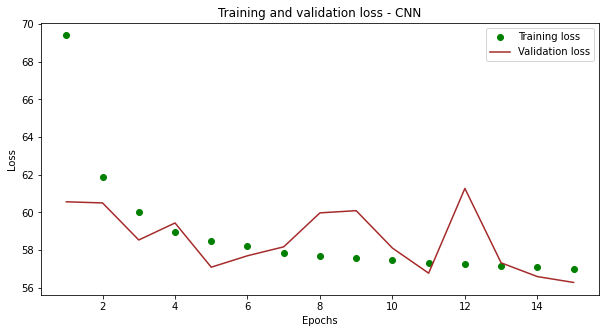

In [136]:
#plotting trainig and validation loss
import matplotlib.pyplot as plt

cnn_mse = cnn_history.history['mse']
cnn_val_mse = cnn_history.history['val_mse']
cnn_loss = cnn_history.history['loss']
cnn_val_loss = cnn_history.history['val_loss']

epochs = range(1, len(cnn_mse) + 1)
#epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10, 5))
# "bo" is for "blue dot"
plt.plot(epochs[:], cnn_loss[:], 'bo', color='green', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs[:], cnn_val_loss[:], 'b', color='brown', label='Validation loss')
plt.title('Training and validation loss - CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

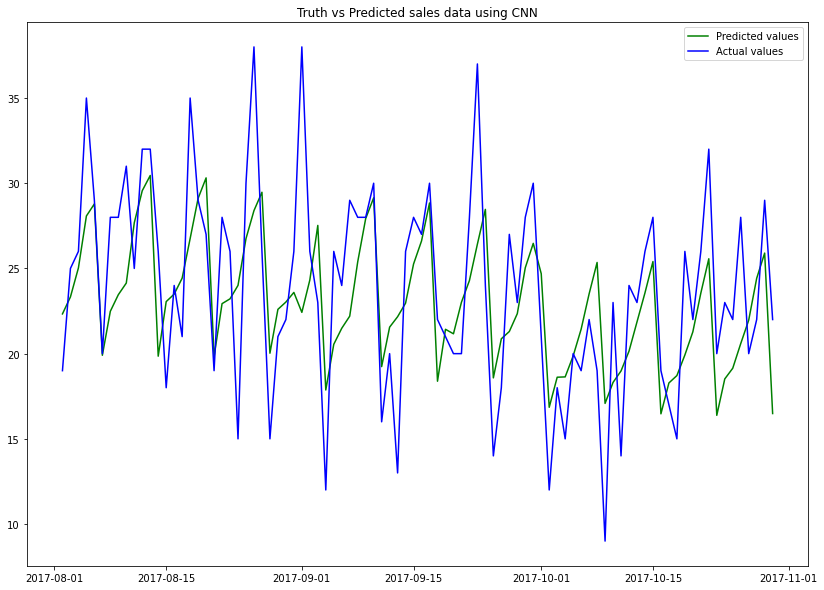

In [140]:
#plotting truth v/s predicted sales data using CNN model
y_pred_cnn_df = pd.DataFrame(y_pred_cnn)
plt.figure(figsize=(14, 10))

plt.plot(y_date[:90], y_pred_cnn[:90], 'b', color='green', label='Predicted values')
plt.plot(y_date[:90], y_test_v2[:90], 'b', color='blue', label='Actual values')
plt.title('Truth vs Predicted sales data using CNN')
plt.legend()

plt.show()

<div class="alert alert-block alert-info"> <b><h3>LSTM</h3></b> </div>

In [141]:
#LSTM model configuration
model_lstm = Sequential()
model_lstm.add(LSTM(42, activation='sigmoid', input_shape=(x_train_series_v2.shape[1], x_train_series_v2.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer='rmsprop', metrics=['mae', 'mse',  'mape'])
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 42)                7392      
                                                                 
 dense_4 (Dense)             (None, 1)                 43        
                                                                 
Total params: 7,435
Trainable params: 7,435
Non-trainable params: 0
_________________________________________________________________


In [142]:
#fitting model on training data 
lstm_history = model_lstm.fit(x_train_series_v2, y_train_v2, validation_data=(x_val_series_v2, y_val_v2), epochs=20, batch_size=128, verbose=2)


Epoch 1/20
5229/5229 - 217s - loss: 524.6346 - mae: 13.5514 - mse: 524.6346 - mape: 26.0785 - val_loss: 81.4970 - val_mae: 6.7708 - val_mse: 81.4970 - val_mape: 82604.7344 - 217s/epoch - 41ms/step
Epoch 2/20
5229/5229 - 246s - loss: 65.6164 - mae: 6.1731 - mse: 65.6164 - mape: 14.8458 - val_loss: 79.2770 - val_mae: 6.8031 - val_mse: 79.2770 - val_mape: 80384.0703 - 246s/epoch - 47ms/step
Epoch 3/20
5229/5229 - 195s - loss: 62.1910 - mae: 6.0336 - mse: 62.1910 - mape: 14.4593 - val_loss: 63.7926 - val_mae: 6.1070 - val_mse: 63.7926 - val_mape: 79856.8359 - 195s/epoch - 37ms/step
Epoch 4/20
5229/5229 - 192s - loss: 60.7752 - mae: 5.9735 - mse: 60.7752 - mape: 14.2963 - val_loss: 61.9310 - val_mae: 6.0039 - val_mse: 61.9310 - val_mape: 74178.6562 - 192s/epoch - 37ms/step
Epoch 5/20
5229/5229 - 187s - loss: 59.9527 - mae: 5.9353 - mse: 59.9527 - mape: 14.1999 - val_loss: 66.9933 - val_mae: 6.3348 - val_mse: 66.9933 - val_mape: 72878.6328 - 187s/epoch - 36ms/step
Epoch 6/20
5229/5229 - 191s

In [143]:
model_lstm.save("LSTM_MODEL.h5")

In [144]:
#predicting on test data
y_pred_lstm = model_lstm.predict(x_test_v2)

2375/2375 [==============================] - 65s 27ms/step


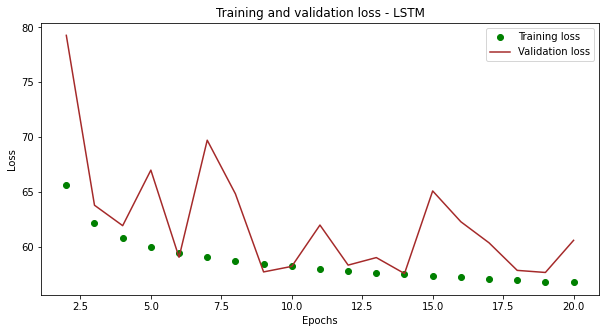

In [189]:
#plotting training and validation loss using LSTM
import matplotlib.pyplot as plt

mse = lstm_history.history['mse']
val_mse = lstm_history.history['val_mse']
loss = lstm_history.history['loss']
val_loss = lstm_history.history['val_loss']

epochs = range(1, len(mse) + 1)
#epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10, 5))
# "bo" is for "blue dot"
plt.plot(epochs[1:], loss[1:], 'bo', color='green', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs[1:], val_loss[1:], 'b', color='brown', label='Validation loss')
plt.title('Training and validation loss - LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


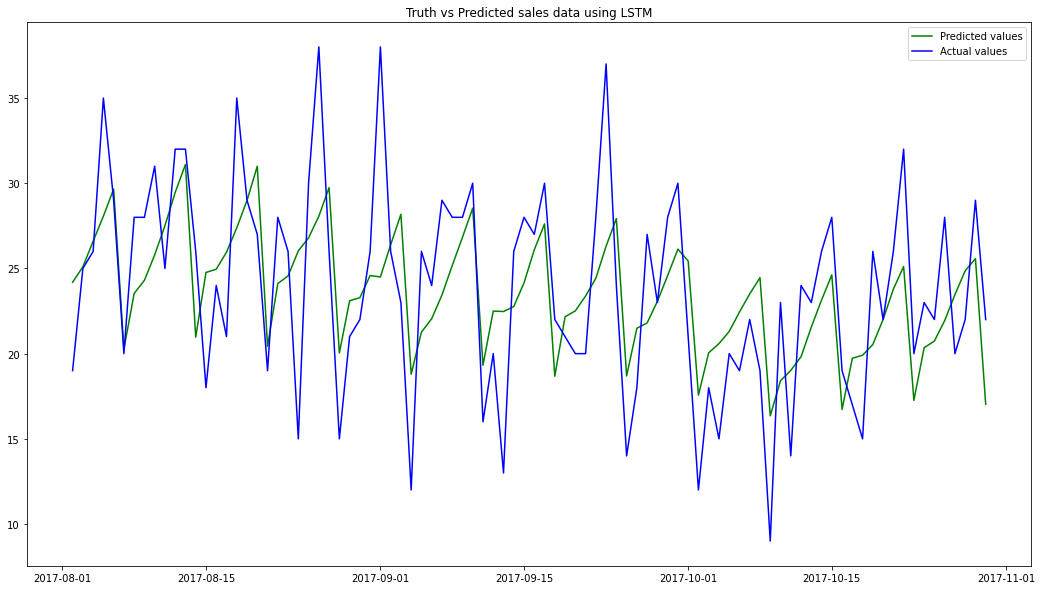

In [191]:
#plotting graph: Truth v/s predicted sales data using LSTM
y_pred_lstm_df = pd.DataFrame(y_pred_lstm)
plt.figure(figsize=(18, 10))

plt.plot(y_date[:90], y_pred_lstm[:90], 'b', color='green', label='Predicted values')
plt.plot(y_date[:90], y_test_v2[:90], 'b', color='blue', label='Actual values')
plt.title('Truth vs Predicted sales data using LSTM')
plt.legend()

plt.show()

In [146]:
#LSTM
print('LSTM test rmse:', np.sqrt(mean_squared_error(y_test_v2, y_pred_lstm)))
print ('LSTM test R2 score', r2_score(y_test_v2, y_pred_lstm))
print('LSTM test MAE:', mean_absolute_error(y_test_v2, y_pred_lstm))
print ('LSTM test MAPE score', mean_absolute_percentage_error(y_test_v2, y_pred_lstm))
print ('LSTM test MSE score', mean_squared_error(y_test_v2, y_pred_lstm))

LSTM test rmse: 8.64055421801217
LSTM test R2 score 0.9186026259187086
LSTM test MAE: 6.553032574440303
LSTM test MAPE score 0.12922089248712326
LSTM test MSE score 74.6591771944079


<div class="alert alert-block alert-info"> <b><h3>GRU</h3></b> </div>

In [147]:
#GRU model configuration
model_gru = Sequential() 
model_gru.add(GRU(75, return_sequences=True,input_shape=(x_train_series_v2.shape[1], x_train_series_v2.shape[2])))
model_gru.add(GRU(units=30, return_sequences=True))
model_gru.add(GRU(units=30))
model_gru.add(Dense(units=1))

model_gru.compile(loss='mae', optimizer='adam',metrics=['mse', 'mae', 'mape'])
model_gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 42, 75)            17550     
                                                                 
 gru_1 (GRU)                 (None, 42, 30)            9630      
                                                                 
 gru_2 (GRU)                 (None, 30)                5580      
                                                                 
 dense_5 (Dense)             (None, 1)                 31        
                                                                 
Total params: 32,791
Trainable params: 32,791
Non-trainable params: 0
_________________________________________________________________


In [148]:
#fitting model on training data 
gru_history = model_gru.fit(x_train_series_v2, y_train_v2, epochs=20, batch_size=64, validation_data=(x_val_series_v2, y_val), shuffle=False)


Epoch 1/20
10457/10457 [==============================] - 1125s 105ms/step - loss: 12.6415 - mse: 438.9110 - mae: 12.6415 - mape: 26.7805 - val_loss: 6.0378 - val_mse: 66.4321 - val_mae: 6.0378 - val_mape: 70091.5234
Epoch 2/20
10457/10457 [==============================] - 1598s 153ms/step - loss: 5.8981 - mse: 60.8278 - mae: 5.8981 - mape: 13.8477 - val_loss: 5.7942 - val_mse: 58.1315 - val_mae: 5.7942 - val_mape: 69487.1406
Epoch 3/20
10457/10457 [==============================] - 1154s 110ms/step - loss: 5.7955 - mse: 57.5458 - mae: 5.7955 - mape: 13.6878 - val_loss: 5.7796 - val_mse: 57.4892 - val_mae: 5.7796 - val_mape: 67997.7344
Epoch 4/20
10457/10457 [==============================] - 1623s 155ms/step - loss: 5.7630 - mse: 56.6101 - mae: 5.7630 - mape: 13.6294 - val_loss: 5.7582 - val_mse: 56.7867 - val_mae: 5.7582 - val_mape: 63694.2617
Epoch 5/20
10457/10457 [==============================] - 1612s 154ms/step - loss: 5.7460 - mse: 56.1484 - mae: 5.7460 - mape: 13.6028 - val_

In [165]:
model_gru.save("GRU_MODEL.h5")

In [150]:
#predicting on test data
y_pred_gru = model_gru.predict(x_test_v2)

2375/2375 [==============================] - 42s 17ms/step


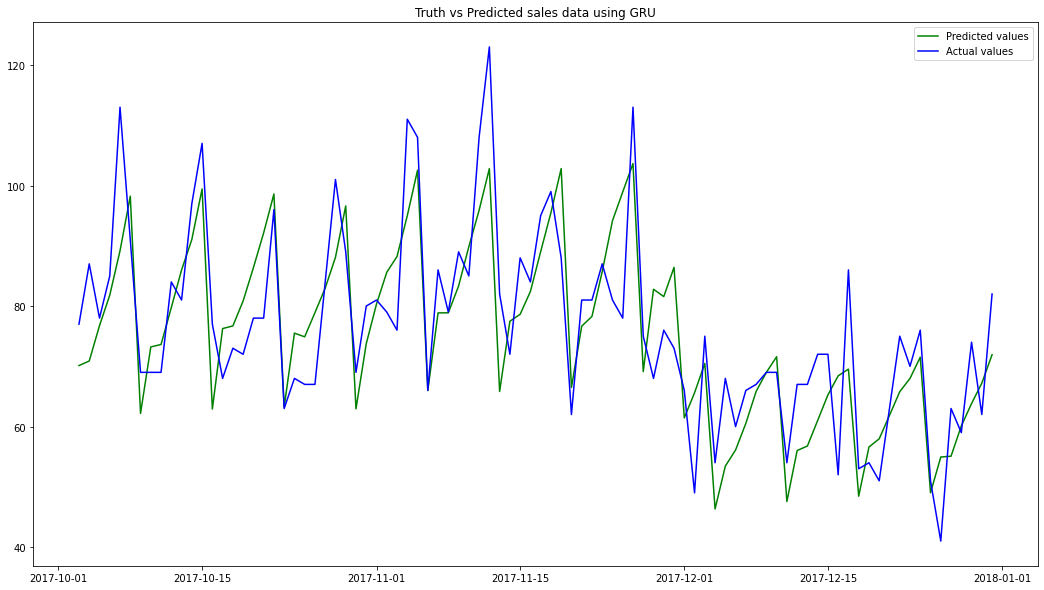

In [151]:
#plotting truth v/s sales data using GRU
y_pred_gru_df = pd.DataFrame(y_pred_gru)
plt.figure(figsize=(18, 10))

plt.plot(y_date[75910:], y_pred_gru[75910:], 'b', color='green', label='Predicted values')
plt.plot(y_date[75910:], y_test_v2[75910:], 'b', color='blue', label='Actual values')
plt.title('Truth vs Predicted sales data using GRU')
plt.legend()

plt.show()

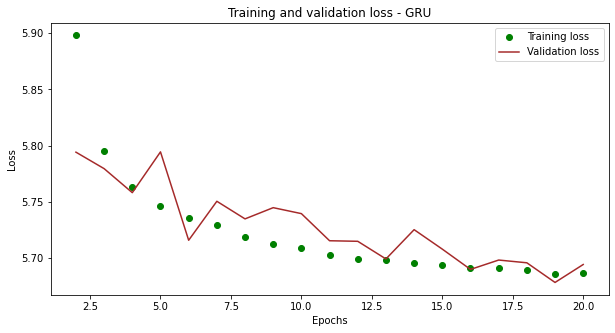

In [183]:
#plotting training and validation loss using GRU
import matplotlib.pyplot as plt

mse = gru_history.history['mse']
val_mse = gru_history.history['val_mse']
loss = gru_history.history['loss']
val_loss = gru_history.history['val_loss']

epochs = range(1, len(mse) + 1)
#epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10, 5))
# "bo" is for "blue dot"
plt.plot(epochs[1:], loss[1:], 'bo', color='green', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs[1:], val_loss[1:], 'b', color='brown', label='Validation loss')
plt.title('Training and validation loss - GRU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [184]:
# Calculating various error metrics for GRU
print ('GRU test R2 score', r2_score(y_test_v2, y_pred_gru))
print('GRU test MAE:', mean_absolute_error(y_test_v2, y_pred_gru))
print ('GRU test MAPE score', mean_absolute_percentage_error(y_test_v2, y_pred_gru))
print ('GRU test MSE score', mean_squared_error(y_test_v2, y_pred_gru))
print('GRU test rmse:', np.sqrt(mean_squared_error(y_test_v2, y_pred_gru)))

GRU test R2 score 0.9299598708326832
GRU test MAE: 6.150213257902547
GRU test MAPE score 0.12302259424730157
GRU test MSE score 64.24210207321418
GRU test rmse: 8.015117096662667


<div class="alert alert-block alert-info"> <b><h3>CNN-LSTM</h3></b> </div>

<b>Description of the model:</B>

The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model.

When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence.

The CNN will be defined to expect 2 timesteps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction.

In [156]:
#Model parameters
epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [159]:
#Reshape input data from [samples, timesteps, features] into [samples, subsequences, timesteps, features]
subsequences = 2
timesteps = x_train_series_v2.shape[1]
x_train_series_sub = x_train_series_v2.reshape((x_train_series_v2.shape[0], subsequences, timesteps, 1))
x_val_series_sub = x_val_series_v2.reshape((x_val_series_v2.shape[0], subsequences, timesteps, 1))
print('Train set shape', x_train_series_sub.shape)
print('Validation set shape', x_val_series_sub.shape)


#CNN-LSTM model
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, x_train_series_sub.shape[2], x_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)


Train set shape (669200, 2, 21, 1)
Validation set shape (167300, 2, 21, 1)


In [160]:
#fitting model on training data
cnn_lstm_history = model_cnn_lstm.fit(x_train_series_sub, y_train, validation_data=(x_val_series_sub, y_val), epochs=epochs, verbose=2)


Epoch 1/40
20913/20913 - 151s - loss: 73.8490 - val_loss: 65.8943 - 151s/epoch - 7ms/step
Epoch 2/40
20913/20913 - 139s - loss: 65.2921 - val_loss: 63.7206 - 139s/epoch - 7ms/step
Epoch 3/40
20913/20913 - 141s - loss: 64.2526 - val_loss: 67.9522 - 141s/epoch - 7ms/step
Epoch 4/40
20913/20913 - 137s - loss: 63.4127 - val_loss: 63.4876 - 137s/epoch - 7ms/step
Epoch 5/40
20913/20913 - 128s - loss: 63.1441 - val_loss: 61.7999 - 128s/epoch - 6ms/step
Epoch 6/40
20913/20913 - 127s - loss: 62.7627 - val_loss: 62.1798 - 127s/epoch - 6ms/step
Epoch 7/40
20913/20913 - 163s - loss: 62.5464 - val_loss: 62.9860 - 163s/epoch - 8ms/step
Epoch 8/40
20913/20913 - 209s - loss: 62.3053 - val_loss: 63.4167 - 209s/epoch - 10ms/step
Epoch 9/40
20913/20913 - 156s - loss: 62.2769 - val_loss: 67.1272 - 156s/epoch - 7ms/step
Epoch 10/40
20913/20913 - 135s - loss: 62.0991 - val_loss: 62.1061 - 135s/epoch - 6ms/step
Epoch 11/40
20913/20913 - 133s - loss: 62.1400 - val_loss: 61.6023 - 133s/epoch - 6ms/step
Epoch 1

In [162]:
model_cnn_lstm.save("CNN-LSTM_MODEL.h5")

In [202]:
x_train_series_v2.shape

(669200, 42, 1)

In [197]:
x_test_v2.shape

x_train_series_v2 = x_train_v2.values.reshape((x_train_v2.shape[0], x_train_v2.shape[1], 1))
subsequences = 2
timesteps = x_train_series_v2.shape[1]
x_train_series_sub = x_train_series_v2.reshape((x_train_series_v2.shape[0], subsequences, timesteps, 1))

(76000, 42)

In [203]:
#prediction on test data
subsequences = 2
timesteps = x_test_v2_series.shape[1] // subsequences
x_test_v2_series_sub = x_test_v2_series.reshape((x_test_v2_series.shape[0], subsequences, timesteps, 1))
y_pred_cnn_lstm = model_cnn_lstm.predict(x_test_v2_series_sub)

2375/2375 [==============================] - 10s 3ms/step


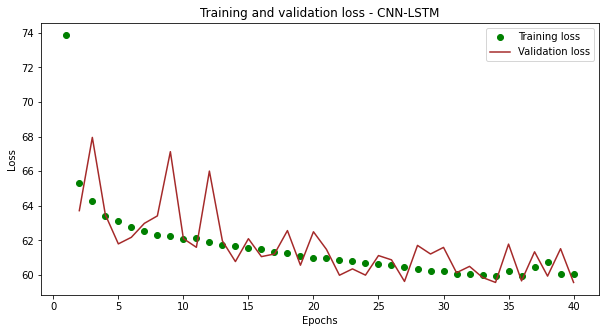

In [211]:
import matplotlib.pyplot as plt

loss = cnn_lstm_history.history['loss']
val_loss = cnn_lstm_history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs[:], loss[:], 'bo', color='green', label='Training loss')
plt.plot(epochs[1:], val_loss[1:], 'b', color='brown', label='Validation loss')
plt.title('Training and validation loss - CNN-LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



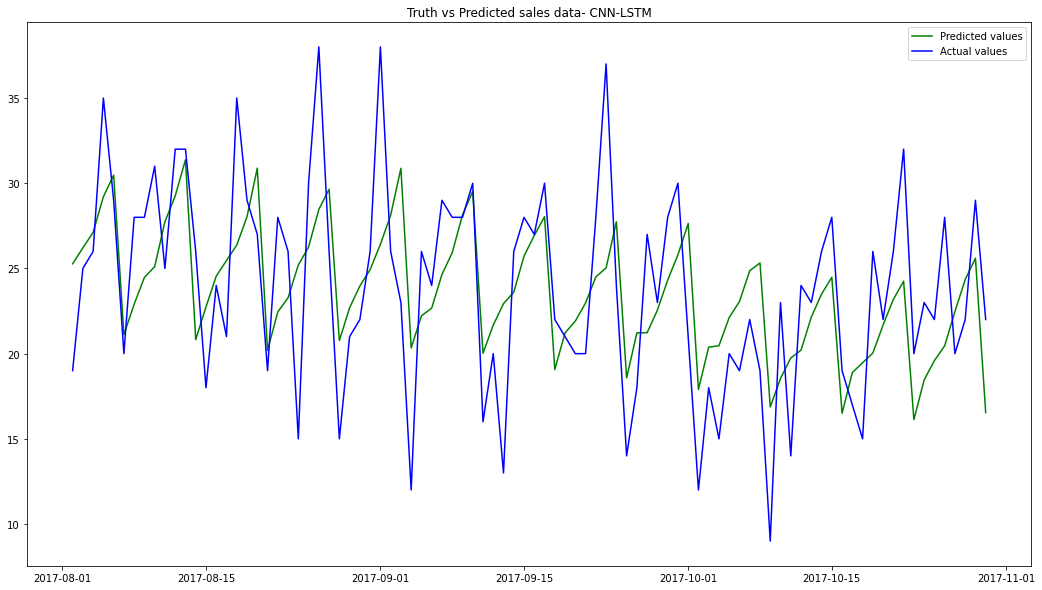

In [215]:
#plotting truth v/s sales data using CNN-LSTM
y_pred_cnn_lstm_df = pd.DataFrame(y_pred_cnn_lstm)
plt.figure(figsize=(18, 10))

plt.plot(y_date[:90], y_pred_cnn_lstm[:90], 'b', color='green', label='Predicted values')
plt.plot(y_date[:90], y_test_v2[:90], 'b', color='blue', label='Actual values')
plt.title('Truth vs Predicted sales data- CNN-LSTM')
plt.legend()

plt.show()

In [210]:
print('CNN-LSTM test rmse:', np.sqrt(mean_squared_error(y_test, y_pred_cnn_lstm)))
print ('CNN-LSTM test R2 score', r2_score(y_test, y_pred_cnn_lstm))
print('CNN-LSTM test MAE:', mean_absolute_error(y_test, y_pred_cnn_lstm))
print ('CNN-LSTM test MAPE score', mean_absolute_percentage_error(y_test, y_pred_cnn_lstm))
print ('CNN-LSTM test MSE score', mean_squared_error(y_test, y_pred_cnn_lstm))

CNN-LSTM test rmse: 8.562703904742213
CNN-LSTM test R2 score 0.9200627785836069
CNN-LSTM test MAE: 6.550084536715557
CNN-LSTM test MAPE score 0.13220753821469003
CNN-LSTM test MSE score 73.31989816028752


<div class="alert alert-block alert-info"> <b><h3>References</h3></b> </div>



https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/
https://towardsdatascience.com/machine-learning-for-store-demand-forecasting-and-inventory-optimization-part-1-xgboost-vs-9952d8303b48
https://medium.datadriveninvestor.com/multivariate-time-series-using-gated-recurrent-unit-gru-1039099e545a
https://www.hindawi.com/journals/complexity/2020/6622927/
https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
https://srdas.github.io/DLBook2/
